## Basic similarity
This short notebook illustrates the process of encoding any image using simple dimensionality reduction.
It was created only as a baseline and comparison for other models, and should be able to only diffrentiate between the same picture with different scalings/distrotions.

In [ ]:
# imports needed for the encdoing calculation
import numpy as np
from cv2 import resize, INTER_AREA

In [ ]:
# imports needed for downloading and distorting the photos
import os
import requests, PIL, io
import cv2
# create some data by downnloading and distorting images
def link_to_numpy(link):
  response = requests.get(link)
  image_bytes = io.BytesIO(response.content)
  img = np.array(PIL.Image.open(image_bytes))
  return img

img_links = ["https://thumbs-prod.si-cdn.com/86veGiDdvMQOopL9mLcyDuyvbjQ=/1072x720/filters:no_upscale()/https://public-media.si-cdn.com/filer/0f/be/0fbef764-3c01-481c-956c-b5661f4e6f31/kheops-pyramid-1581-971.jpg",
             "https://thumbs-prod.si-cdn.com/05dRDX04qZQAwAF16-KPvDldz4k=/800x600/filters:no_upscale()/https://public-media.si-cdn.com/filer/94/3b/943b17ca-2115-42bb-85b0-28b9333361d6/oct2015_d06_pyramids.jpg"
             ]
imgs = [link_to_numpy(link) for link in img_links]
qualities=[95,65,35]
fxs=[1,0.5,0.25]
fys=[1,0.5,0.25]
dir_name = "test_data"
#os.mkdir(dir_name)
for label, img in enumerate(imgs):
  for fx in fxs:
    for fy in fys:
      resized_img = cv2.resize(img,dsize=(0,0),fx=fx,fy=fy,interpolation=cv2.INTER_CUBIC)
      for quality in qualities:
        img_name = "_".join([str(label),str(fx),str(fy),str(quality)])+".jpg"
        img_filepath = os.path.join(dir_name,img_name)
        cv2.imwrite(img_filepath, resized_img, [int(cv2.IMWRITE_JPEG_QUALITY), quality])


In [ ]:
names = os.listdir(dir_name)
paths = [os.path.join(dir_name, name) for name in names]
sizes = [(path.split('/')[1], int(os.stat(path).st_size/1000)) for path in paths]
for entry in sizes:
  print(entry[0],": ",entry[1],"kb")

1_0.5_0.25_35.jpg :  3 kb
1_1_1_95.jpg :  58 kb
1_1_1_65.jpg :  27 kb
1_0.5_0.5_65.jpg :  8 kb
0_0.5_0.5_95.jpg :  81 kb
1_1_0.5_35.jpg :  9 kb
0_1_0.5_65.jpg :  49 kb
1_0.25_0.25_95.jpg :  8 kb
1_0.5_0.5_35.jpg :  5 kb
0_0.5_0.25_95.jpg :  42 kb
0_0.25_0.5_65.jpg :  14 kb
0_0.5_1_65.jpg :  50 kb
1_0.5_0.5_95.jpg :  25 kb
1_1_0.25_95.jpg :  26 kb
0_1_1_65.jpg :  109 kb
0_1_0.5_95.jpg :  144 kb
1_1_0.5_95.jpg :  43 kb
0_0.25_0.25_95.jpg :  22 kb
1_0.25_1_95.jpg :  25 kb
0_0.25_0.25_35.jpg :  5 kb
1_0.5_0.25_95.jpg :  15 kb
1_0.5_1_35.jpg :  9 kb
0_1_0.25_95.jpg :  77 kb
1_0.5_0.25_65.jpg :  5 kb
1_0.25_0.25_65.jpg :  3 kb
1_1_0.25_65.jpg :  8 kb
0_0.25_0.5_35.jpg :  9 kb
0_0.5_0.25_35.jpg :  9 kb
1_0.25_0.5_35.jpg :  3 kb
0_1_1_95.jpg :  228 kb
1_0.5_1_95.jpg :  41 kb
1_0.25_1_65.jpg :  8 kb
0_0.5_0.25_65.jpg :  15 kb
1_0.25_0.5_65.jpg :  4 kb
1_0.5_1_65.jpg :  14 kb
1_0.25_0.25_35.jpg :  2 kb
1_0.25_0.5_95.jpg :  14 kb
0_1_0.25_35.jpg :  17 kb
0_0.5_1_95.jpg :  143 kb
1_1_0.5_65.jpg : 

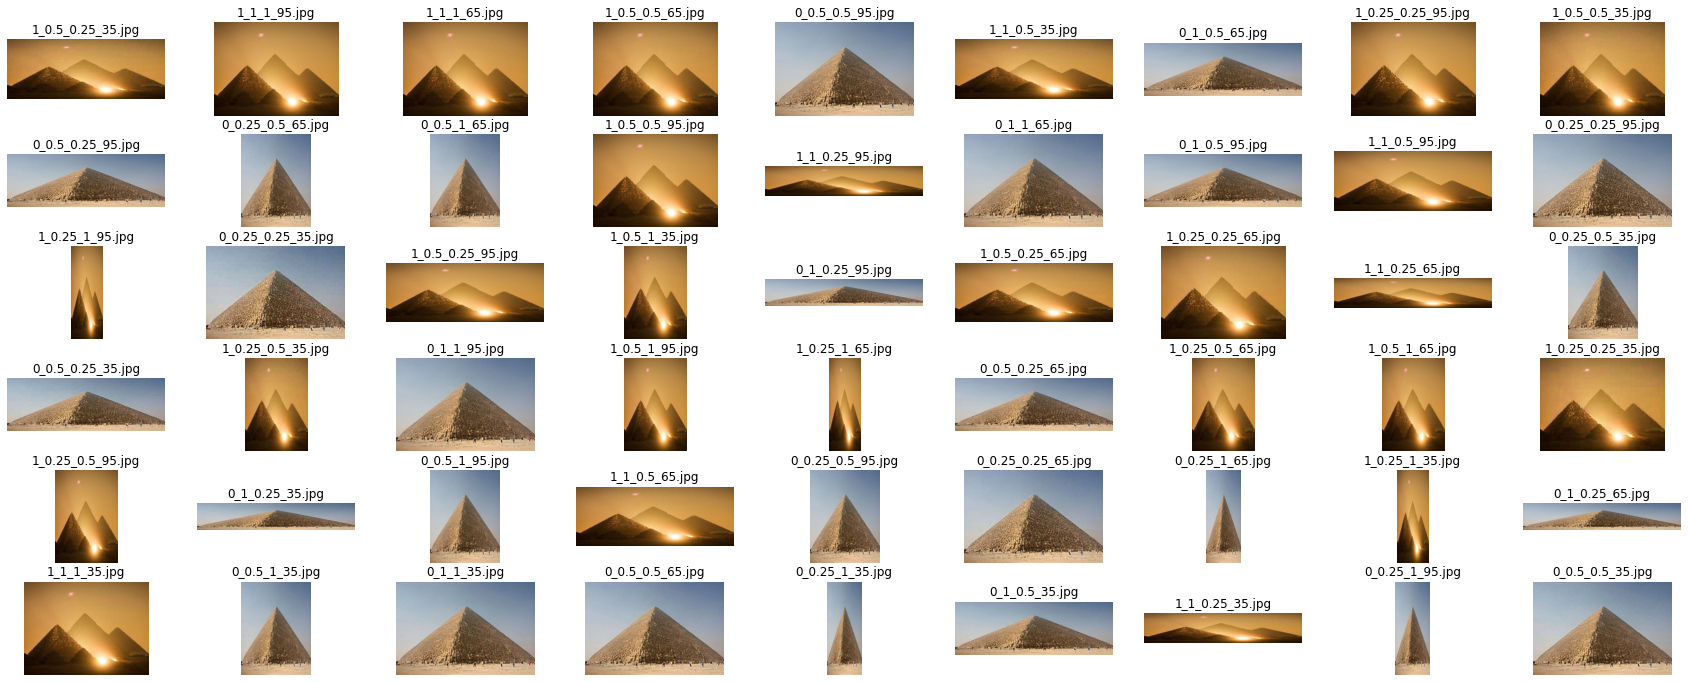

In [ ]:
#Visualize imgs
from matplotlib import pyplot as plt
plt.figure(figsize=(30,12))
for idx, path in enumerate(paths):
  img = cv2.imread(path)
  plt.subplot(6,len(paths)/6,idx+1)
  plt.imshow(img)
  plt.axis('off')
  plt.title(path.split('/')[1])
plt.show()  

In [ ]:
def get_vector_encodings(imgs,interpolation_type = INTER_AREA,
                         encoding_shape = (2,2),flatten_RGB_channel=True):
  # resize images to small shape
  encodings = [resize(img,encoding_shape,interpolation = interpolation_type) for img in imgs]
  encodings = np.array(encodings)
  
  # flatten out the encodings  
  if flatten_RGB_channel is True:
    flat_encodings = encodings.reshape(len(encodings),-1)
  else:
    flat_encodings = encodings.reshape(len(encodings),-1,3)
  return flat_encodings

  

def get_scalar_encodings(vector_encodings,n_bits_in_bin = 4):
  """
  vector_encodings: a numpy array of shape (n_encodings, n_pixels, n_channels)
                    n_pixels should be 4 if the "encoding_shape" argument from function
                      "get_vector_encodings" is (2,2)
                    n_channels should be 3
                    n_encodings corresponds to number of supplied vector encodings
  n_bits_in_bin:  should be a power of 2, where the bigger the number,
                  the less accurate the algorithm becomes
  """

  #if len(vector_encodings.shape)==2: # if the rgb channel is non-existent
  #  vector_encodings =vector_encodings.reshape(len(encodings),-1,3)

  max_bin = 256/n_bits_in_bin
  n_channels = vector_encodings.shape[2]
  multiplication_array = np.power(max_bin,np.arange(n_channels)).astype('int') 

  # take mean over pixels for each colour 
  encodings_mean = np.mean(vector_encodings,axis=1)

  # calculate bin id for each entry
  encodings_binned = np.floor(encodings_mean / n_bits_in_bin).astype('uint')

  # multiply the id of the bin with corresponding power of 2
  encoding_int = [np.sum(enc* multiplication_array,dtype='int') for enc in encodings_binned]
  #print(encoding_int)
  return encoding_int

def get_pairwise_distance_matrix_numpy(A,B,use_sqrt=False):
  """
  A: np array of encodings, shape: (n_A_encodings,encoding_size)
  B: np array of encodings, shape: (n_B_encodings,encoding_size)
  returns:
  pairwise_distances of shape: (n_A_encodings,n_B_encodings)
  """
  assert A.shape[1] == B.shape[1] and len(A.shape)==len(B.shape) and len(A.shape)==2
  # numpy hacking starts
  xy_diff = A[:, :, None] - B[:, :, None].T
  # numpy hacking done
  squared_sum_over_features = (xy_diff * xy_diff).sum(axis=1)
  if use_sqrt:
    return np.sqrt(squared_sum_over_features+1e-7)
  else:
    return squared_sum_over_features

def get_distance_numpy(A,B,use_sqrt=False):
  """
  A:  encoding, shape: (encoding_size)
  B:  encoding, shape: (encoding_size)  
  """
  d = get_pairwise_distance_matrix_numpy(A[None,:],B[None,:],use_sqrt=use_sqrt)
  return np.squeeze(d)


from sklearn.metrics import pairwise_distances
def get_pairwise_distance_matrix_sklearn(A,B,n_jobs):
  """
  WARNING: this function might only be faster for very big amtrices and only when n_jobs != 1
  A: np array of encodings, shape: (n_A_encodings,encoding_size)
  B: np array of encodings, shape: (n_B_encodings,encoding_size)
  returns:
  pairwise_distances of shape: (n_A_encodings,n_B_encodings)
  """
  return pairwise_distances(X=A, Y=B, metric='euclidean', n_jobs=n_jobs, force_all_finite=True)



In [ ]:
imgs = [cv2.imread(path) for path in paths]

In [ ]:
vec_encs = get_vector_encodings(imgs,interpolation_type = cv2.INTER_AREA,
                  encoding_shape = (2,2),flatten_RGB_channel=False)
ids = get_scalar_encodings(vec_encs,n_bits_in_bin = 4)

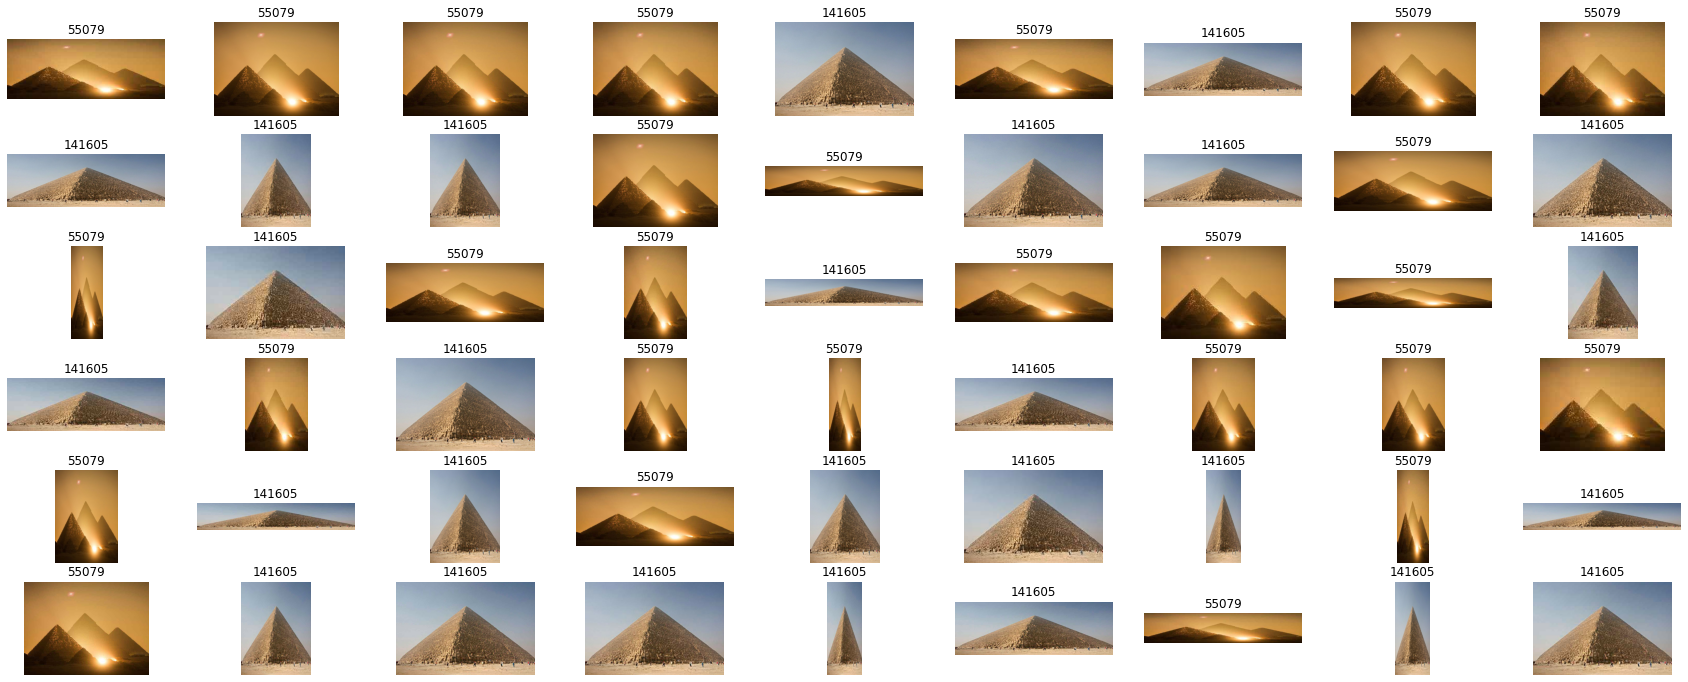

In [ ]:
plt.figure(figsize=(30,12))
for idx, path in enumerate(paths):
  img = cv2.imread(path)
  plt.subplot(6,len(paths)/6,idx+1)
  plt.imshow(img)
  plt.axis('off')
  plt.title(str(ids[idx]))
plt.show()  

## Show similarity matrix illustrating distances between images above according

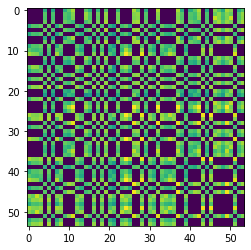

In [ ]:
flat_vec_encs = vec_encs.reshape(vec_encs.shape[0],-1)
distance_matrix = get_pairwise_distance_matrix_numpy(flat_vec_encs,flat_vec_encs,use_sqrt=False)
plt.imshow(distance_matrix)
plt.show()